In [1]:
import pathlib

import tensorflow as tf
tf.enable_eager_execution()

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
main_path = pathlib.Path(r"C:\Users\Toby-PC\Documents\code\oct\input")
train_path = main_path / 'train'
test_path = main_path / 'test'
val_path = main_path / 'val'

In [4]:
for item in main_path.iterdir():
    print(item)

C:\Users\Toby-PC\Documents\code\oct\input\test
C:\Users\Toby-PC\Documents\code\oct\input\train
C:\Users\Toby-PC\Documents\code\oct\input\val


In [5]:
import random
all_image_paths = list(main_path.glob('*/*/*.jpeg'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

all_image_paths = all_image_paths[:5000]

image_count = len(all_image_paths)
image_count

5000

In [6]:
all_image_paths[:10]

['C:\\Users\\Toby-PC\\Documents\\code\\oct\\input\\train\\NORMAL\\NORMAL-5651778-1.jpeg',
 'C:\\Users\\Toby-PC\\Documents\\code\\oct\\input\\train\\CNV\\CNV-1279887-65.jpeg',
 'C:\\Users\\Toby-PC\\Documents\\code\\oct\\input\\train\\CNV\\CNV-198660-35.jpeg',
 'C:\\Users\\Toby-PC\\Documents\\code\\oct\\input\\train\\NORMAL\\NORMAL-917949-12.jpeg',
 'C:\\Users\\Toby-PC\\Documents\\code\\oct\\input\\train\\DME\\DME-3064922-197.jpeg',
 'C:\\Users\\Toby-PC\\Documents\\code\\oct\\input\\train\\CNV\\CNV-2655276-34.jpeg',
 'C:\\Users\\Toby-PC\\Documents\\code\\oct\\input\\train\\NORMAL\\NORMAL-9301250-3.jpeg',
 'C:\\Users\\Toby-PC\\Documents\\code\\oct\\input\\train\\CNV\\CNV-7710023-193.jpeg',
 'C:\\Users\\Toby-PC\\Documents\\code\\oct\\input\\train\\CNV\\CNV-9642260-39.jpeg',
 'C:\\Users\\Toby-PC\\Documents\\code\\oct\\input\\train\\CNV\\CNV-9642959-123.jpeg']

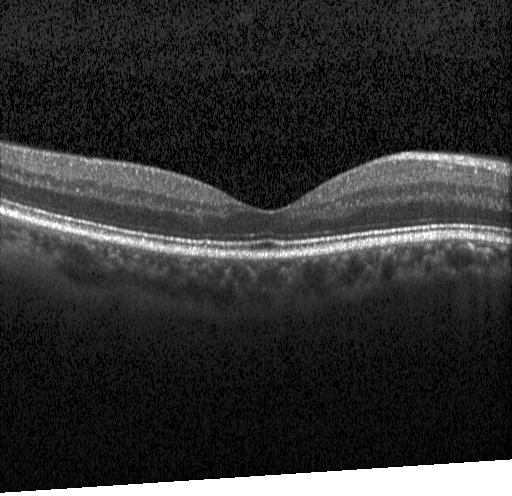

In [7]:
import IPython.display as display

image_path = random.choice(all_image_paths)
display.display(display.Image(image_path))

In [8]:
label_names = sorted(set(item.name for item in main_path.glob('*/*') if item.is_dir()))
print(label_names)

['CNV', 'DME', 'DRUSEN', 'NORMAL']


In [9]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}

In [10]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [3, 0, 0, 3, 1, 0, 3, 0, 0, 0]


In [11]:
img_path = all_image_paths[0]
img_path

'C:\\Users\\Toby-PC\\Documents\\code\\oct\\input\\train\\NORMAL\\NORMAL-5651778-1.jpeg'

In [12]:
img_raw = tf.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x...


In [13]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(496, 768, 1)
<dtype: 'uint8'>


In [14]:
img_final = tf.image.resize_images(img_tensor, [192, 192])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(192, 192, 1)
0.0
1.0


In [15]:
target_im_size = [256, 256]

def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize_images(image, target_im_size)
    image /= 255.0  # normalize to [0,1] range
#     image = tf.squeeze(image)

    return image

In [16]:
def load_and_preprocess_image(path):
    image = tf.read_file(path)
    return preprocess_image(image)

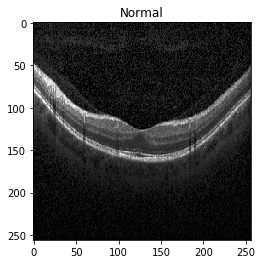

In [17]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

# plt.imshow(img_final[:,:,0])
plt.imshow(load_and_preprocess_image(img_path)[:,:,0], cmap='gray')
plt.grid(False)
plt.title(label_names[label].title())
print()

In [18]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

In [19]:
print('shape: ', repr(path_ds.output_shapes))
print('type: ', path_ds.output_types)
print()
print(path_ds)

shape:  TensorShape([])
type:  <dtype: 'string'>

<DatasetV1Adapter shapes: (), types: tf.string>


In [20]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

Instructions for updating:
Colocations handled automatically by placer.


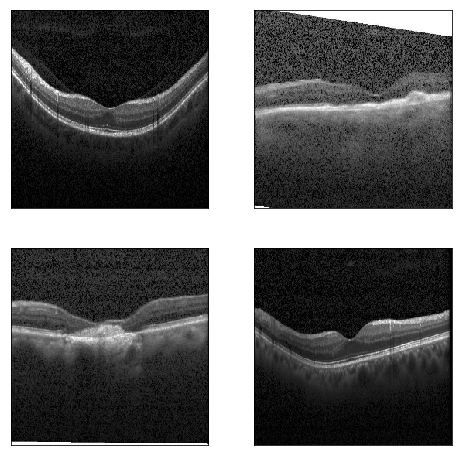

In [21]:
plt.figure(figsize=(8,8))
for n,image in enumerate(image_ds.take(4)):
  plt.subplot(2,2,n+1)
  plt.imshow(image[:,:,0], cmap='gray')
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

In [22]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [23]:
for label in label_ds.take(10):
  print(label_names[label.numpy()])

NORMAL
CNV
CNV
NORMAL
DME
CNV
NORMAL
CNV
CNV
CNV


In [24]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [25]:
print('image shape: ', image_label_ds.output_shapes[0])
print('label shape: ', image_label_ds.output_shapes[1])
print('types: ', image_label_ds.output_types)
print()
print(image_label_ds)

image shape:  (256, 256, 1)
label shape:  ()
types:  (tf.float32, tf.int64)

<DatasetV1Adapter shapes: ((256, 256, 1), ()), types: (tf.float32, tf.int64)>


In [26]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

# The tuples are unpacked into the positional arguments of the mapped function 
def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<DatasetV1Adapter shapes: ((256, 256, 1), ()), types: (tf.float32, tf.int32)>

In [27]:
BATCH_SIZE = 32

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = image_label_ds.shuffle(buffer_size=200)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 256, 256, 1), (?,)), types: (tf.float32, tf.int32)>

In [28]:
ds = image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 256, 256, 1), (?,)), types: (tf.float32, tf.int32)>

In [34]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='SAME'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(len(label_names), activation=tf.nn.softmax)
])

In [35]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [36]:
# model.summary()

In [37]:
EPOCHS = 10
steps_per_epoch = image_count // BATCH_SIZE

In [38]:
history = model.fit(ds, epochs=EPOCHS, steps_per_epoch=steps_per_epoch)

Epoch 1/10


InvalidArgumentError: Incompatible shapes: [32] vs. [32,128,128]
	 [[{{node metrics_1/acc/Equal}}]] [Op:StatefulPartitionedCall]

In [ ]:
ds.take(1)

In [ ]:
for im, targ in ds.take(1):
    print(targ)